In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime
import os
import re
from tqdm import tqdm
%matplotlib inline
import warnings
import glob
warnings.simplefilter(action='ignore', category=FutureWarning)
#Last edited: 2024029 by JS
import poligrain as plg
import matplotlib.pyplot as plt
import pypwsqc 
import pypwsqc.pwspyqc_dev_js as pyqc

Load PWS and Reference data sets (netCDF files), both hourly temporal aggregation

In [4]:
# paths need to be adjusted on github
ds_pws = xr.open_dataset("/home/IWS/seidel/PWS_data/PWS_RT/PWS_RT_1h_v2024_10.nc")
#ds_pws = xr.open_dataset("/home/IWS/seidel/PWS_data/AMS/AMS_PWS_1h_res.nc")
#ds_pws = xr.open_dataset("/home/IWS/seidel//PWS_code/PWS_Lazio/PWS_Lazio_1h.nc")

Load PWS data into memory (faster read/write)

In [5]:
ds_pws.load()

<xarray.Dataset>
Dimensions:      (id: 101, time: 77405)
Coordinates:
  * id           (id) <U10 'RT_PWS_001' 'RT_PWS_002' ... 'RT_PWS_101'
    elevation    (id) int64 661 685 687 700 726 703 ... 312 379 381 328 363 359
    longitude    (id) float64 9.425 9.331 9.368 9.382 ... 9.202 9.2 9.232 9.234
    latitude     (id) float64 48.38 48.4 48.44 48.43 ... 48.54 48.55 48.54 48.54
    mac_address  (id) <U17 '70:ee:50:05:be:c6' ... '70:ee:50:02:25:b8'
  * time         (time) datetime64[ns] 2014-12-31T23:00:00 ... 2023-10-31T03:...
Data variables:
    rainfall     (time, id) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    title:         PWS data Reutlingen
    institution:   University Stuttgart
    history:       Version 2.0
    references:    N/A
    date_created:  2024-10-01 12:43:41
    Conventions:   OPENSENSE V0
    location:      Reutlingen
    source:        Netatmo
    comment:       naming convention OpenSense v0, resampled to 1h from origi...

Add cartesian coordinates to dataset using `poligrain` tools

In [6]:
# if lat /lon istead of latitude/longitude
#ds_pws.coords['x'], ds_pws.coords['y'] = plg.spatial.project_point_coordinates(
#     ds_pws.lon, ds_pws.lat, target_projection="EPSG:25832",
# )

ds_pws.coords['x'], ds_pws.coords['y'] = plg.spatial.project_point_coordinates(
     ds_pws.longitude, ds_pws.latitude, target_projection="EPSG:25832",
)
 # for the Netherlands, EPSG 25831 would be correct

Let's look at the first PWS station in the data set, now with x and y coordinates

In [7]:
ds_pws.isel(id=0)

<xarray.Dataset>
Dimensions:      (time: 77405)
Coordinates:
    id           <U10 'RT_PWS_001'
    elevation    int64 661
    longitude    float64 9.425
    latitude     float64 48.38
    mac_address  <U17 '70:ee:50:05:be:c6'
  * time         (time) datetime64[ns] 2014-12-31T23:00:00 ... 2023-10-31T03:...
    x            float64 5.315e+05
    y            float64 5.358e+06
Data variables:
    rainfall     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    title:         PWS data Reutlingen
    institution:   University Stuttgart
    history:       Version 2.0
    references:    N/A
    date_created:  2024-10-01 12:43:41
    Conventions:   OPENSENSE V0
    location:      Reutlingen
    source:        Netatmo
    comment:       naming convention OpenSense v0, resampled to 1h from origi...

Same precedure for the reference data set. These are 20 randomly chosen time series from pixels from the gauge-adjusteed KNMI radar product (Reference?)

In [8]:
#path needs to be changed for github
ds_ref=xr.open_dataset("/home/IWS/seidel/RT_Pluviodata/10_netCDF_QC/Reutlingen_Pluviodata_2024_v2_1hourly_qc.nc")
#ds_ref=xr.open_dataset("/home/IWS/seidel/PWS_data/AMS/RadarRef_AMS.nc")
#ds_ref=xr.open_dataset("/home/IWS/seidel/PWS_code/PWS_Lazio/HydroNet_Lazio_60min.nc")

ds_ref.load()
ds_ref.coords['x'], ds_ref.coords['y'] = plg.spatial.project_point_coordinates(
    ds_ref.longitude, ds_ref.latitude, target_projection="EPSG:25832",
)
# again for the Netherlands, EPSG 25831 would be correct

Now the calculations of different distance and indicator correlation matrices

In [9]:
# Distance and indicator correlations of PWS
dist_mtx_pws, indcorr_mtx_pws = pyqc.calc_indic_corr_all_stns(
    ds_pws.rainfall, 
    ds_pws.rainfall, 
    prob=0.99,
    max_distance=30e3,
    min_valid_overlap=2*24*30,
)

 15%|█▍        | 15/101 [00:09<00:51,  1.68it/s]/home/IWS/seidel/.cache/pypoetry/virtualenvs/pypwsqc-N-_pEr4N-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/IWS/seidel/.cache/pypoetry/virtualenvs/pypwsqc-N-_pEr4N-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 101/101 [01:07<00:00,  1.49it/s]


Let's see how it looks....

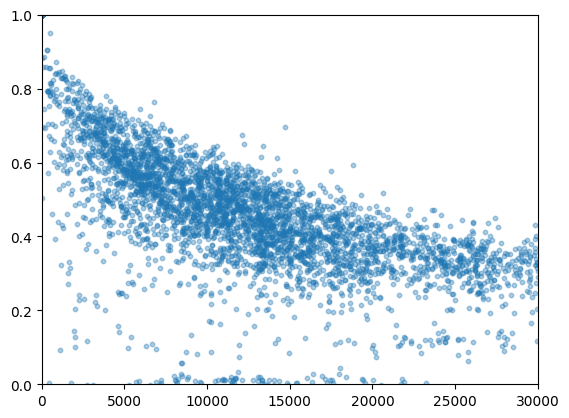

In [10]:
plt.scatter(dist_mtx_pws, indcorr_mtx_pws, alpha=0.2, s=10)
#plt.scatter(dist_mtx_ref, corr_mtx_ref, s=10)
plt.ylim(0, 1)
plt.xlim(0, 30e3);

In [11]:
# Distance and indicator correlations of reference data
dist_mtx_ref, indcorr_mtx_ref = pyqc.calc_indic_corr_all_stns(
    ds_ref.rainfall, 
    ds_ref.rainfall,
    max_distance=30e3, 
    prob=0.99,
    min_valid_overlap=2*24*30,)

  8%|▊         | 1/12 [00:00<00:01,  6.76it/s]

100%|██████████| 12/12 [00:01<00:00,  7.79it/s]


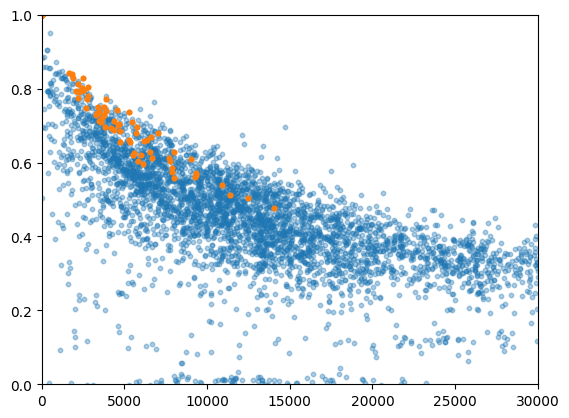

In [12]:
#plt.scatter(dist_vals, corr_vals, alpha=0.2, s=10)
plt.scatter(dist_mtx_pws, indcorr_mtx_pws, alpha=0.2, s=10)
plt.scatter(dist_mtx_ref, indcorr_mtx_ref, s=10)
plt.ylim(0, 1)
plt.xlim(0, 30e3);

Finally the distance and indicator correlations matrices between PWS and reference data are calculated.

Note: In contrast to the individual matrices calcualted above, the correct time information is relevant here. In some cases, there might be a shift between the time series (e.g. UTC vs. CET) which yields low and improper indicator correlations. 
Time shifts can be corrected like this:

`ds_ref.rainfall.shift(time=-1)`

In [13]:
# IMPORTANT !!!!!!!!!!!!
# I have switched the order of the first two arguments here
# so that dim `id` is the one of the PWS

dist_mtx_ref_pws, indcorr_mtx_ref_pws= pyqc.calc_indic_corr_all_stns(
    ds_ref.rainfall,#.sel(time=slice('2014-12-31T23:00:00','2023-10-31T03:00:00')), 
    ds_pws.rainfall.shift(time=+1),#.sel(time=slice('2014-12-31T23:00:00','2023-10-31T03:00:00')), 
    #ds_ref.rainfall,#.shift(time=-1),#.sel(time=slice('2014-12-31T23:00:00','2023-10-31T03:00:00')), 
    prob=0.99,
    min_valid_overlap=2*24*30,)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


As the calculations of all the matrices may be time consuming depending on the size of the data sets, it makes sense to save these to netCDF files for further processing

In [38]:
#dist_mtx_ref.to_netcdf((r'/home/IWS/seidel/PWS_code/PWS_Lazio/HydroNet_Lazio_distmtx.nc'))
#indcorr_mtx_ref.to_netcdf((r'/home/IWS/seidel/PWS_code/PWS_Lazio/HydroNet_Lazio_corrmtx.nc'))
#dist_mtx_pws.to_netcdf((r'/home/IWS/seidel/PWS_code/PWS_Lazio/PWS_Lazio_distmtx.nc'))
#indcorr_mtx_pws.to_netcdf((r'/home/IWS/seidel/PWS_code/PWS_Lazio/PWS_Lazio_corrmtx.nc'))
#dist_mtx_ref_pws.to_netcdf((r'/home/IWS/seidel/PWS_code/PWS_Lazio/Lazio_distmtx_ref_pws.nc'))
#indcorr_mtx_ref_pws.to_netcdf((r'/home/IWS/seidel/PWS_code/PWS_Lazio/Lazio_corrmtx_ref_pws.nc'))

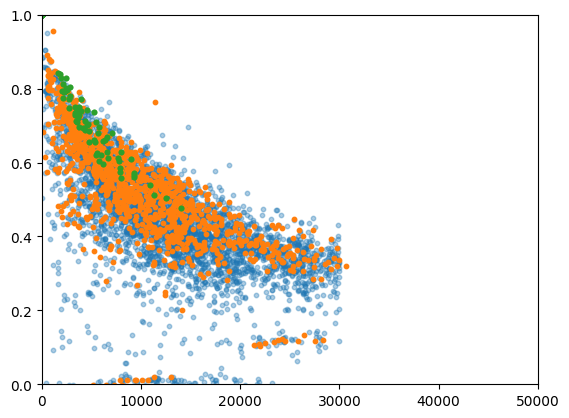

In [14]:
plt.scatter(dist_mtx_pws, indcorr_mtx_pws, alpha=0.2, s=10)
plt.scatter(dist_mtx_ref_pws, indcorr_mtx_ref_pws, s=10)
plt.scatter(dist_mtx_ref, indcorr_mtx_ref, s=10)
plt.ylim(0, 1)
plt.xlim(0, 50e3);

Application of the indicator correlation filter

In [16]:
indcorr_results = pyqc.indicator_correlation_filter(indcorr_mtx_ref,dist_mtx_ref,indcorr_mtx_ref_pws,
    dist_mtx_ref_pws, max_distance=20000, bin_size=1000, threshold=0.1);

/home/IWS/seidel/.cache/pypoetry/virtualenvs/pypwsqc-N-_pEr4N-py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/home/IWS/seidel/github/pypwsqc/src/pypwsqc/pwspyqc_dev_js.py:192: RuntimeWarning: invalid value encountered in scalar divide
  score = sum(IndCorrGood.values * np.array(RankSumWeights)) / NormedWeights
/home/IWS/seidel/.cache/pypoetry/virtualenvs/pypwsqc-N-_pEr4N-py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/home/IWS/seidel/github/pypwsqc/src/pypwsqc/pwspyqc_dev_js.py:192: RuntimeWarning: invalid value encountered in scalar divide
  score = sum(IndCorrGood.values * np.array(RankSumWeights)) / NormedWeights


ValueError: None of the data falls within bins with edges array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
        9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
       18000, 19000])

In [17]:
dist_mtx_ref_pws

<xarray.DataArray (id: 12, id_neighbor: 101)>
array([[24985.71395355, 18742.06179141, 17149.20612601, ...,
         1166.40626701,  1756.49827119,  1914.90864219],
       [24369.172     , 17644.07279082, 16743.9967057 , ...,
         2117.19387488,  3000.25682065,  3102.6831578 ],
       [22719.01931143, 16391.28884955, 14925.70461065, ...,
         2841.27229007,   911.14497176,   878.84430697],
       ...,
       [20485.47475082, 13227.87211447, 13538.58217324, ...,
         7560.84984622,  6927.0682228 ,  6893.25442391],
       [18846.0871941 , 11749.45124325, 11716.43079626, ...,
         7951.44253466,  6689.78399771,  6613.03779697],
       [21576.5357491 , 14094.97401759, 16376.72776513, ...,
        13472.21314109, 13372.78637631, 13359.07884698]])
Coordinates:
  * id           (id) <U5 'RT_01' 'RT_02' 'RT_03' ... 'RT_10' 'RT_11' 'RT_12'
  * id_neighbor  (id_neighbor) <U10 'RT_PWS_001' 'RT_PWS_002' ... 'RT_PWS_101'

In [18]:
# Ideas to implement
# - get max range from dist_mtx_ref
# - threshold parameter
bins = np.arange(0, 20e3, 1e3)

# quantile parameter not too low, otherwise the line becomes to wiggly - depends on data
binned_indcorr_ref = indcorr_mtx_ref.groupby_bins(
    dist_mtx_ref, bins=bins
).quantile(0.1).bfill(dim='group_bins')

binned_indcorr_ref

<xarray.DataArray (group_bins: 19)>
array([0.82838251, 0.82838251, 0.77268254, 0.70882557, 0.67071405,
       0.61645501, 0.60169593, 0.56374101, 0.56142079, 0.56142079,
       0.53946114, 0.51126893, 0.5043306 , 0.47756705, 0.47756705,
              nan,        nan,        nan,        nan])
Coordinates:
  * group_bins  (group_bins) object (0.0, 1000.0] ... (18000.0, 19000.0]
    quantile    float64 0.1

In [97]:
for stn in indcorr_results.id_neighbor[indcorr_results.indcorr_good]:
    #foo.sel(id_neighbor=stn)
    binned_indcorr_ref.plot(color='k')
    indcorr_results.plot.scatter(x='dist', y='indcorr', color='grey', alpha=0.5, s=10)
    #foo.where(foo.indcorr_good).plot.scatter(x='dist', y='indcorr', color='b', alpha=0.4, s=3)
    plt.scatter(dist_mtx_ref, indcorr_mtx_ref, color='r', alpha=0.5, s=10)
    indcorr_results.sel(id_neighbor=stn).plot.scatter(x='dist', y='indcorr', color='lime', s=15)
    IndCorr_Score= str(f"{indcorr_results.sel(id_neighbor=stn).indcorr_score.values:.2f}")  # noqa: PD011
    plt.text(20000,1, 'IndCorr Score: '+IndCorr_Score)
    plt.savefig(str(stn.values)+'_indscore.png', dpi=200)#
    plt.close();
    #raise Exception

In [98]:
!pwd

/home/IWS/seidel/github/pypwsqc/docs/notebooks
